In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import copy

In [2]:
import torch

In [3]:
from behavior_model import LVBehaviorModel, FVBehaviorModel
from synthetic_model import LVTrajSynthetic, FVTrajSynthetic

In [4]:
file_path = 'Synthetic_crash_scenarios.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Model

In [6]:
## Network Parameters 
gru_hidden_size = 256 # Size of GRU's hidden layer
mlp_hidden_size = 128 # Size of MLP's hidden layer
acc_min, acc_max, acc_interval = -9.5, 7, 0.25
output_size = int((acc_max - acc_min)/acc_interval) + 1
input_size = 5

model_lv = LVBehaviorModel(input_size, gru_hidden_size, mlp_hidden_size, output_size).to(device)
model_lv.load_state_dict(torch.load('.\\weights\\bc_lv_val_05.pth')) 
model_lv.eval()

LVBehaviorModel(
  (gru): GRU(5, 256, batch_first=True)
  (mlp): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=67, bias=True)
    (3): LogSoftmax(dim=2)
  )
)

In [7]:
## Network Parameters 
acc_min, acc_max, acc_interval = -9.5, 4, 0.25
gru_hidden_size = 256 # Size of GRU's hidden layer
mlp_hidden_size = 128 # Size of MLP's hidden layer
output_size = int((acc_max - acc_min)/acc_interval) + 1
input_size = 5

model_fv = FVBehaviorModel(input_size, gru_hidden_size, mlp_hidden_size, output_size).to(device)
model_fv.load_state_dict(torch.load('.\\weights\\bc_fv_val_05.pth'))
model_fv.eval()

FVBehaviorModel(
  (gru): GRU(5, 256, batch_first=True)
  (mlp): Sequential(
    (0): Linear(in_features=384, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=55, bias=True)
    (3): LogSoftmax(dim=2)
  )
  (mlp2): Sequential(
    (0): Linear(in_features=97, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
)

## Crash Generation Example

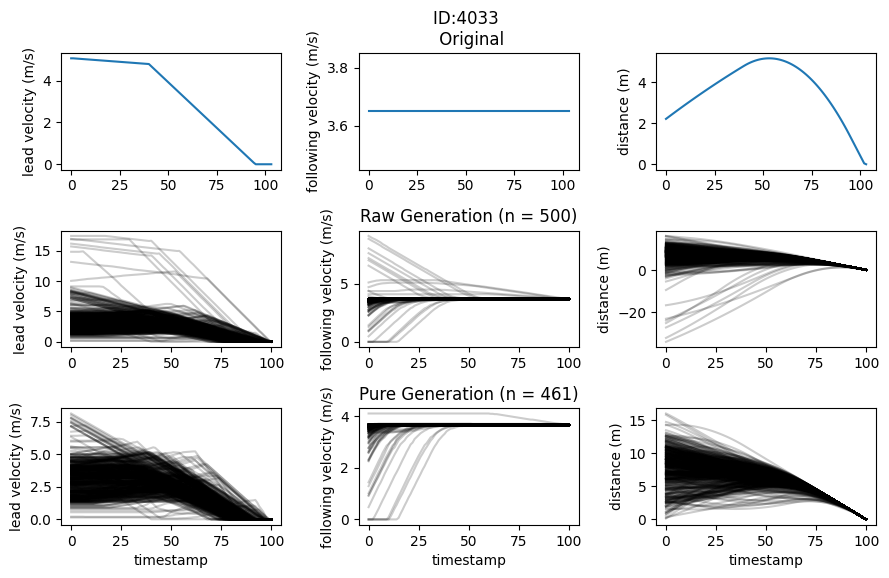

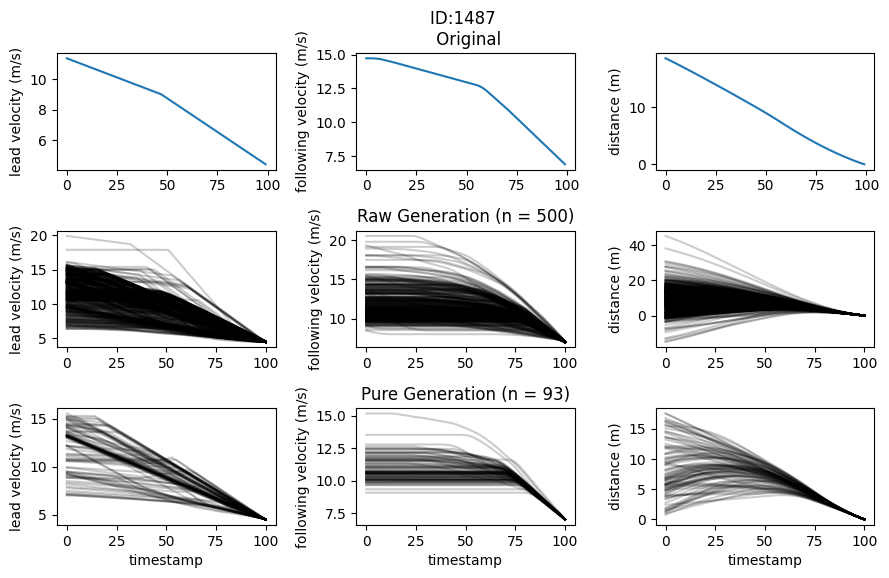

In [10]:
for _ in range(2):
    ID = random.randint(1, 5000)
#     ID = 2530
#     ID = 1421
    v_l_i = df[df["id"]==ID].iloc[:, 3].to_numpy()
    v_f_i = df[df["id"]==ID].iloc[:, 2].to_numpy()
    d_i = df[df["id"]==ID].iloc[:, 4].to_numpy()
    t_i = df[df["id"]==ID].iloc[:, 1].to_numpy()

    #### Gen LV first
    n = 500 # number of trajectories
    V_inputLV, A_inputLV = np.zeros(n), np.zeros(n)
    V_f0_inputLV, A_f0_inputLV = np.zeros(n), np.zeros(n)

    a_0 = (v_l_i[-2]-v_l_i[-3])/0.05
    # V_inputLV = V_inputLV+v_l_i[-1]
    V_inputLV = V_inputLV+v_l_i[-2]
    A_inputLV = A_inputLV+a_0
    V_f0_inputLV = V_f0_inputLV+v_f_i[-2]
    A_f0_inputLV = A_f0_inputLV+(v_f_i[-2]-v_f_i[-3])/0.05

    KM_l_LV = LVTrajSynthetic(model_lv,V_inputLV,A_inputLV,V_f0_inputLV,A_f0_inputLV,T_traj=5,mode="rs",device=device)
    ## KM_l_LV = np.flip(KM_l_LV,axis=1)

    V_f_inputFV, A_f_inputFV, D_inputFV = np.zeros(n), np.zeros(n), np.zeros(n)
    V_l_inputFV = np.zeros((n,KM_l_LV.shape[1]))

    a_f_0 = (v_f_i[-2]-v_f_i[-3])/0.05
    # V_f_inputFV = V_f_inputFV+v_f_i[-1]
    V_f_inputFV = V_f_inputFV+v_f_i[-2]
    A_f_inputFV = A_f_inputFV+a_f_0
    # D_inputFV = D_inputFV+d_i[-1]
    V_l_inputFV = copy.deepcopy(KM_l_LV[:,:,1])

    KM_l_FV, KM_f_FV = FVTrajSynthetic(model_fv,V_f_inputFV,A_f_inputFV,D_inputFV,V_l_inputFV,mode="rs",device=device)
#     KM_l_FV, KM_f_FV = TrajGen_FV_GRU2B(model_fv,V_f_inputFV,A_f_inputFV,D_inputFV,V_l_inputFV,mode="rs",device=device)
    KM_l, KM_f = np.flip(KM_l_FV,axis=1), np.flip(KM_f_FV,axis=1)
    
    V_l = copy.deepcopy(KM_l[:,:,1])
    V_f = copy.deepcopy(KM_f[:,:,1])
    D = copy.deepcopy(KM_l[:,:,0] - KM_f[:,:,0])
    idx_noprecrash = np.all(D[:,:-1] > 0, axis=1)
    idx_wrongvfacc = np.abs((V_f[:,-1]-V_f[:,-2])/0.05 - A_f_inputFV)<0.75
    idx_wrongvlacc = np.abs((V_l[:,-1]-V_l[:,-2])/0.05 - A_inputLV)<0.75
    idx_filter = np.all([idx_noprecrash,idx_wrongvfacc,idx_wrongvlacc],axis=0)
#     idx_filter = np.all([idx_noprecrash,idx_wrongvfacc],axis=0)
    V_l_filter, V_f_filter, D_filter = V_l[idx_filter], V_f[idx_filter], D[idx_filter]


    plt.figure(figsize=(9, 9))

    plt.subplot(5, 3, 1)
    plt.plot(df[df["id"]==ID].iloc[:, 3].to_numpy())
    plt.ylabel("lead velocity (m/s)")
    plt.subplot(5, 3, 2)
    plt.plot(df[df["id"]==ID].iloc[:, 2].to_numpy())
    plt.ylabel("following velocity (m/s)")
    plt.title(f"ID:{ID} \n Original")
    plt.subplot(5, 3, 3)
    plt.plot(df[df["id"]==ID].iloc[:, 4].to_numpy())
    plt.ylabel("distance (m)")

    plt.subplot(5, 3, 4)
    plt.plot(V_l.T, "k-", alpha=.2)
    plt.ylabel("lead velocity (m/s)")
    plt.subplot(5, 3, 5)
    plt.plot(V_f.T, "k-", alpha=.2)
    plt.title(f"Raw Generation (n = {n})")
    plt.ylabel("following velocity (m/s)")
    plt.subplot(5, 3, 6)
    plt.plot(D.T, "k-", alpha=.2)
    plt.ylabel("distance (m)")

    plt.subplot(5, 3, 7)
    plt.plot(V_l_filter.T, "k-", alpha=.2)
    plt.xlabel("timestamp")
    plt.ylabel("lead velocity (m/s)")
    plt.subplot(5, 3, 8)
    plt.plot(V_f_filter.T, "k-", alpha=.2)
    plt.title(f"Pure Generation (n = {V_f_filter.shape[0]})")
    plt.xlabel("timestamp")
    plt.ylabel("following velocity (m/s)")
    plt.subplot(5, 3, 9)
    plt.plot(D_filter.T, "k-", alpha=.2)
    plt.xlabel("timestamp")
    plt.ylabel("distance (m)") 

    plt.tight_layout()
    plt.show()